In [1]:
# Setup

import networkx as nx
import itertools as it
import matplotlib.pyplot as plt
import math
import scipy
import pickle
import os
import logging

logging.basicConfig(filename=f"Default_Log.txt", level=logging.INFO, format='%(asctime)s %(message)s')
if not os.path.exists("Graphs"):
    os.mkdir("Graphs")
os.chdir("Graphs")
BaseDirectory = os.getcwd()

logging.info(BaseDirectory)

In [4]:
def _Edge_Subgraph_Generator(Graph):
#     Iterate through selecting 0, 1, 2, ... edges that will be selected from the edge set of the host graph
    for nEdges in range(Graph.size()+1):
        
#         For each given number of edges that will be selected, select each combination of that many edges from the host graph
        for Edges in it.combinations(Graph.edges(),nEdges):
        
#             Add the respective edge-induced subgraph to the list of all subgraphs
            yield nx.edge_subgraph(Graph, Edges).copy()
    
def _Unique_Edge_Subgraph_Generator(Graph):
#     Iterate through each edge-induced subgraph of the input graph
    UniqueSubgraphs = []
    for subgraph in _Edge_Subgraph_Generator(Graph):
        Unique = True
#         Check if the given subgraph is unique. We will assume it is until we find an isomorphic one
        for UniqueSubgraph in UniqueSubgraphs:
            if nx.is_isomorphic(UniqueSubgraph, subgraph):
                Unique = False
                break
#         Now that we've gone through the entire list (or short cirtuited) we can return this subgraph (if it's unique) or conginue to the next subgraph
        if Unique:
            UniqueSubgraphs.append(subgraph)
            yield subgraph
            
def _Return_Unique(Graphs):
    UniqueGraphs = []
#     Iterate through each of the input graphs
    for Graph in Graphs:
        Unique = True
#         Check if the graph is unique. We will assume it is until we find an isomorphic one
        for UniqueGraph in UniqueGraphs:
            if nx.is_isomorphic(UniqueGraph, Graph):
                Unique = False
                break
#         Now that we've gone through the entire list (or short circuited) we can return ass this graph to the list of unique graphs
        if Unique:
            UniqueGraphs.append(Graph)
    return UniqueGraphs
            
def _Union(Graph1, Graph2):
    return _Return_Unique(set(_Unique_Edge_Subgraph_Generator(Graph1)).union(set(_Unique_Edge_Subgraph_Generator(Graph2))))

def _Intersection(Graph1, Graph2):
#     Determine the smaller and larger of the two graphs
    if Graph1.size() > Graph2.size():
        LargestGraph = Graph1
        SmallestGraph = Graph2
    else:
        LargestGraph = Graph2
        SmallestGraph = Graph1
#     If the smaller of the graphs has 1 or fewer nodes, we want to return the empty graph
    if SmallestGraph.number_of_nodes() < 1:
        return nx.null_graph()
#     Starting with the graph with one node, we find the largest subgraph of the smaller that is also a subgraph of the larger graph
    for SubgraphSize in range(SmallestGraph.size(), 0, -1):
        for Edges in it.combinations(SmallestGraph.edges(), SubgraphSize):
            if nx.algorithms.isomorphism.GraphMatcher(LargestGraph, nx.edge_subgraph(SmallestGraph, Edges).copy()).subgraph_is_monomorphic():
                LargestSubgraph = nx.edge_subgraph(SmallestGraph, Edges).copy()
                break
        if LargestSubgraph:
            break
    return LargestSubgraph

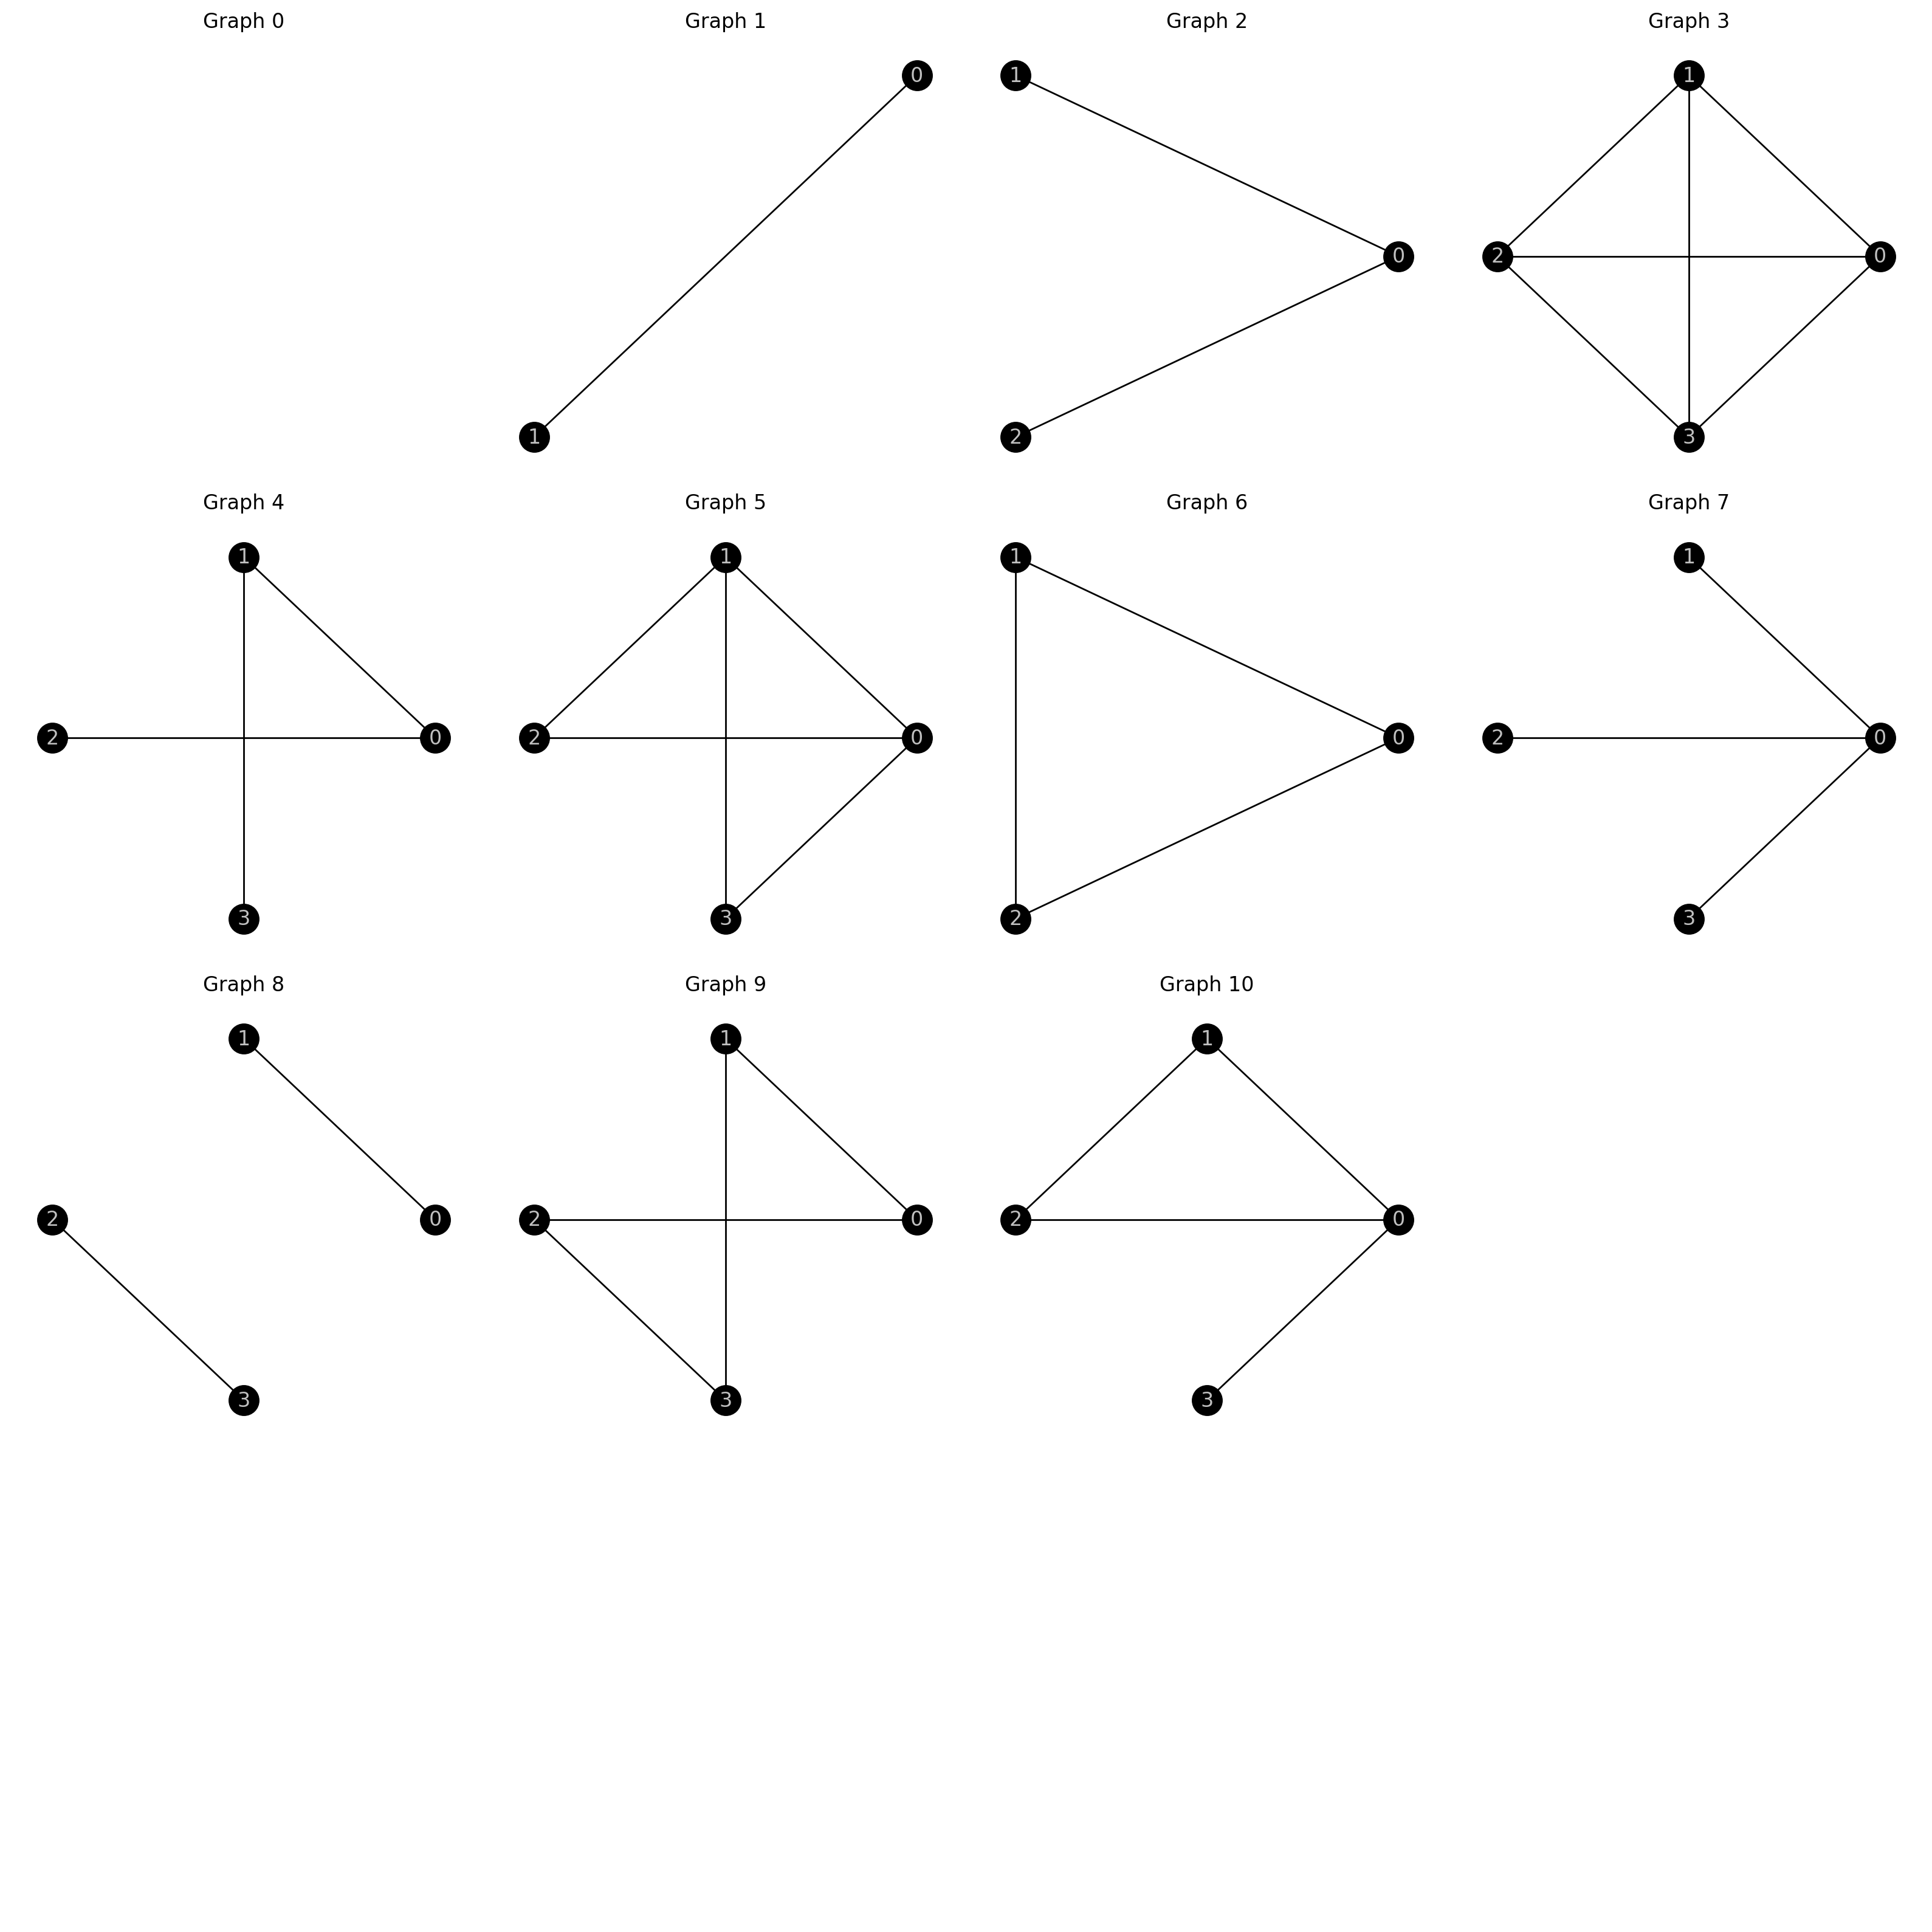

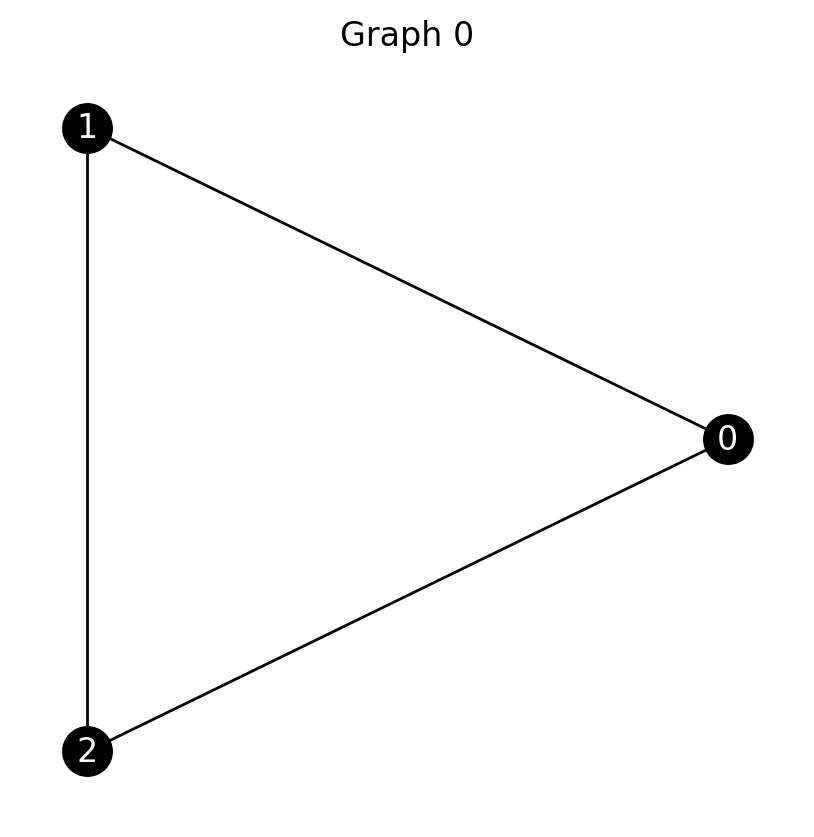

In [10]:
ExampleGraph1 = nx.complete_graph(4)
ExampleGraph2 = nx.cycle_graph(3)
_draw_graph_list(_Union(ExampleGraph1, ExampleGraph2))
_draw_graph(_Intersection(ExampleGraph1, ExampleGraph2))

In [6]:
# Graph Drawing/Exporting

def _draw_graph(Graph):
    Dimension = 1
    FigDimension = 5
    fig,axes = plt.subplots(nrows=Dimension,ncols=Dimension,figsize=(FigDimension,FigDimension),dpi=200)
    nx.draw_circular(Graph, ax=axes, with_labels=True, edge_color='black', node_color='black', font_color='white')
    axes.set_title("Graph 0")
    plt.show()
    plt.close()
    
def _draw_graph_list(GraphList, Names = None):
    if Names == None:
        Names = []
        for i in range(len(GraphList)):
            Names.append(f"Graph {i}")
    if len(GraphList) <= 0:
        return
    elif len(GraphList) == 1:
        Dimension = 1
        FigDimension = min(Dimension*Dimension, 65000/Dimension)
        fig,axes = plt.subplots(nrows=Dimension,ncols=Dimension,figsize=(FigDimension,FigDimension),dpi=200)
        nx.draw_circular(GraphList[0], ax=axes, with_labels=True, edge_color='black', node_color='black', font_color='silver')
        axes.set_title("Graph 0")
    else:
        Dimension = math.ceil(math.sqrt(len(GraphList)))
        FigDimension = min(Dimension*Dimension, 65000/Dimension)
        fig,axes = plt.subplots(nrows=Dimension,ncols=Dimension,figsize=(FigDimension,FigDimension),dpi=200)
        GraphCounter=0
        for x in range(0,Dimension):
            for y in range(0,Dimension):
                if GraphCounter < len(GraphList):
                    axes[x,y].set_title(Names[GraphCounter])
                    nx.draw_circular(GraphList[GraphCounter], ax=axes[x,y], with_labels=True, edge_color='black', node_color='black', font_color='silver')
                    GraphCounter+=1
                else:
                    nx.draw(nx.null_graph(), ax=axes[x,y])
    plt.tight_layout()
    plt.show()
    plt.close()
    return

def _save_coloring(ColoringList, Intersection = None, Union = None, HostGraph = None, FileName = "Default"):
#     This function saves specifically a red blue coloring
    
    fig,axes = plt.subplots(nrows=1, ncols=5, figsize=(10,2.5))
    nx.draw_circular(ColoringList[0], ax=axes[0], with_labels=True, edge_color="red", node_color='black', font_color='silver')
    axes[0].set_title("Red Subgraph")
    
    nx.draw_circular(ColoringList[1], ax=axes[1], with_labels=True, edge_color="blue", node_color='black', font_color='silver')
    axes[1].set_title("Blue Subgraph")
    
    if Intersection == None:
        Intersection = _get_largest_subgraph_of_both(ColoringList[0], ColoringList[1])
    nx.draw_circular(Intersection, ax=axes[2], with_labels=True, edge_color="violet", node_color='black', font_color='silver')
    axes[2].set_title("Intersection")
    
    if HostGraph == None:
        HostGraph = nx.compose(ColoringList[0], ColoringList[1])
    nx.draw_circular(HostGraph, ax=axes[4], with_labels=True, edge_color="black", node_color='black', font_color='silver')
    axes[4].set_title("Host")
    
    if Union == None:
        Union = _get_union_of_both(ColoringList[0], ColoringList[1])
    nx.draw_circular(Union, ax=axes[3], with_labels=True, edge_color="gold", node_color='black', font_color='silver')
    axes[3].set_title("Union")
    
    plt.tight_layout()
    plt.savefig(f"{FileName}.svg")
    plt.close()
    return

def _save_graph(Graph, FileName = "Default", Name = None):
    if Name == None:
        Name = "Graph"
    fig,axes = plt.subplots(nrows=1, ncols=1, figsize=(math.ceil(math.sqrt(Graph.number_of_nodes())),math.ceil(math.sqrt(Graph.number_of_nodes()))))
    nx.draw_circular(Graph, ax=axes, with_labels=True, edge_color="black", node_color="Black", font_color="silver")
    plt.tight_layout()
    plt.savefig(f"{FileName}.svg")
    plt.close()

def _save_graph_list(GraphList, FileName = "Default", Names = None):
    if Names == None:
        Names = []
        for i in range(len(GraphList)):
            Names.append(f"Graph {i}")
    if len(GraphList) <= 0:
        return
    elif len(GraphList) == 1:
        Dimension = 1
        FigDimension = min(Dimension*Dimension, 65000/Dimension)
        fig,axes = plt.subplots(nrows=Dimension,ncols=Dimension,figsize=(FigDimension,FigDimension),dpi=200)
        nx.draw_circular(GraphList[0], ax=axes, with_labels=True, edge_color='black', node_color='black', font_color='silver')
        axes.set_title("Graph 0")
    else:
        Dimension = math.ceil(math.sqrt(len(GraphList)))
        FigDimension = min(Dimension*Dimension, 65000/Dimension)
        fig,axes = plt.subplots(nrows=Dimension,ncols=Dimension,figsize=(FigDimension,FigDimension),dpi=200)
        GraphCounter=0
        for x in range(0,Dimension):
            for y in range(0,Dimension):
                if GraphCounter < len(GraphList):
                    axes[x,y].set_title(Names[GraphCounter])
                    nx.draw_circular(GraphList[GraphCounter], ax=axes[x,y], label=f"Graph {GraphCounter}", with_labels=True, edge_color='black', node_color='black', font_color='silver')
                    GraphCounter+=1
                else:
                    nx.draw(nx.null_graph(), ax=axes[x,y])
    plt.tight_layout()
    plt.savefig(f"{FileName}.svg")
    plt.close()
    return

In [ ]:
# Ordering Functions

def _return_total_ordering(GraphList):
    AdjacencyList = ""
    GraphID = 0
    for Graph in GraphList:
        AdjacencyList += f"{GraphID}"
        HostGraphID = 0
        for HostGraph in GraphList:
            if nx.algorithms.isomorphism.GraphMatcher(HostGraph, Graph).subgraph_is_monomorphic():
                AdjacencyList += f" {HostGraphID}"
            HostGraphID += 1
        AdjacencyList += "\n"
        GraphID += 1
    TotalOrdering = nx.parse_adjlist(AdjacencyList.splitlines(), create_using=nx.DiGraph(), nodetype=int)
    TotalOrdering.remove_edges_from(nx.selfloop_edges(TotalOrdering))
    return TotalOrdering

def _get_poset(GraphList, Ordering = None):
    if Ordering == None:
        Ordering = _return_total_ordering(GraphList)
    AdjacencyList = ""
    GraphID = 0
    for Graph in GraphList:
        AdjacencyList += f"{GraphID}"
        HostGraphID = 0
        for HostGraph in GraphList:
            if HostGraph.size() == (Graph.size()+1):
                if Ordering.has_edge(GraphID, HostGraphID):
                    AdjacencyList += f" {HostGraphID}"
            HostGraphID += 1
        AdjacencyList += "\n"
        GraphID += 1
    return nx.parse_adjlist(AdjacencyList.splitlines(), create_using=nx.DiGraph())

In [ ]:
# Graph Functions

def _get_largest_subgraph_of_both(Graph1, Graph2):
#     
    
    if Graph1.size() > Graph2.size():
        LargestGraph = Graph1
        SmallestGraph = Graph2
    else:
        LargestGraph = Graph2
        SmallestGraph = Graph1
    
    if SmallestGraph.number_of_nodes() < 1:
        return nx.null_graph()
    
    LargestSubgraph = nx.path_graph(1)
    for SubgraphSize in range(SmallestGraph.size(), 0, -1):
        for Edges in it.combinations(SmallestGraph.edges(), SubgraphSize):
            HostLineGraph = nx.line_graph(LargestGraph)
            
            if nx.algorithms.isomorphism.GraphMatcher(LargestGraph, nx.edge_subgraph(SmallestGraph, Edges).copy()).subgraph_is_monomorphic():
                LargestSubgraph = nx.edge_subgraph(SmallestGraph, Edges).copy()
                break
        if LargestSubgraph.size() > 0:
            break
            
    return LargestSubgraph

def _get_union_of_both(Graph1, Graph2, HostSubgraphList = None):
    if HostSubgraphList == None:
        Host = nx.complete_graph(max(Graph1.number_of_nodes(), Graph2.number_of_nodes()))
        HostSubgraphList = _get_unique_edge_induced_subgraphs(Host)
    HostSubgraphList = sorted(HostSubgraphList, key=lambda x:(nx.number_of_edges(x),nx.number_of_nodes(x)))
    for Graph in HostSubgraphList:
        if nx.algorithms.isomorphism.GraphMatcher(Graph,Graph1).subgraph_is_monomorphic() and nx.algorithms.isomorphism.GraphMatcher(Graph,Graph2).subgraph_is_monomorphic():
            return Graph

def _all_edge_induced_subgraphs_generator(Host):
    
#     Iterate through selecting 0, 1, 2, ... edges that will be selected from the edge set of the host graph
    for NumEdgesChosen in range(Host.size()+1):
        
#         For each given number of edges that will be selected, select each combination of that many edges from the host graph
        for Edges in it.combinations(Host.edges(),NumEdgesChosen):
        
#             Add the respective edge-induced subgraph to the list of all subgraphs
            yield nx.edge_subgraph(Host, Edges).copy()

def _return_unique_graphs(GraphList):
#     This function takes in a list of graphs, and returns a list of unique graphs from the input list, taking graph isomorphism as the equivalence relation
    
#     Initialize the list of unique graphs to an empty list
    UniqueGraphs = []
    
#     Iterate over the entire list of graphs
    for Graph in GraphList:
        
#         First assume that the graph is unique up to subgraph isomorphism
        Unique = True
    
#         Iterate through each graph already in the list of unique subgraphs, and if there is a graph in the list of unique subgraphs that is isomorphic to the potentially unique subgraph, we note that and break out of the loop
        for UniqueGraph in UniqueGraphs:
            if nx.is_isomorphic(Graph, UniqueGraph):
                Unique = False
                break
                
#         If none of the already determined unique subgraphs are isomorphic to the held subgraph, then we can safely determine that it is unique up to isomorphism
        if Unique:
            UniqueGraphs.append(Graph)
            
    return UniqueGraphs

def _get_unique_edge_induced_subgraphs(Host):
#     This funciton is essentially a wrapper for returning only the unique subgraphs of an input graph
    return _return_unique_graphs(_all_edge_induced_subgraphs_generator(Host))

def _get_all_colorings(Host, SubgraphList = None):
#     This function takes in a host graph, and a list of subgraphs (or calculates all of them), and returns a list of all red blue colorings associated with coloring every subgraph in the list red and the complement (in the host) blue
#     This function returns a list of tuples where the first index is the red subgraph, and the second index is the blue subgraph
    
#     Initialize the list of colorings to an empty list
    Colorings = []
    
#     If the list of subgraphs isn't passed into this funciton, this funciton will calculate the list of all non-isomorphic subgraphs
    if SubgraphList == None:
        SubgraphList = _get_unique_edge_induced_subgraphs(Host)
    
#     Make the induced colorings and put them into the list of colorings
    for RedColoring in SubgraphList:
        BlueColoring = nx.edge_subgraph(Host, set(Host.edges())-set(RedColoring.edges())).copy()
        Colorings.append(tuple((RedColoring, BlueColoring)))
        
    return Colorings

In [ ]:
# Miscelaneous Functions

def _get_graph_from_file_name(GraphName):
    if "K_" in GraphName:
        if "," in GraphName:
            n,m=FileName.split(".",1)[0].split("K_",1)[1].split(",")
            n=int(n)
            m=int(m)
            return nx.complete_multipartite_graph(n,m)
        else:
            n=FileName.split(".",1)[0].split("K_",1)[1]
            n=int(n)
            return nx.complete_graph(n)
    elif "C_" in GraphName:
            n=FileName.split(".",1)[0].split("C_",1)[1]
            n=int(n)
            return nx.cycle_graph(n)
    elif "P_" in GraphName:
            n=FileName.split(".",1)[0].split("P_",1)[1]
            n=int(n)
            return nx.path_graph(n)

In [ ]:
# Build the unique subgraphs of complete bipartites
os.chdir(BaseDirectory)
MaxN = 3
MaxM = 3
for n in range(1,MaxN+1):
    for m in range(n,MaxM+1):
        os.chdir(BaseDirectory)
        GraphName = f"K_{n},{m}"
        
        if not os.path.exists(f"{GraphName}"):
            os.mkdir(f"{GraphName}")
        logging.info(f"Moving into {BaseDirectory}/{GraphName}")
        os.chdir(GraphName)
        logging.info(f"  The directory looks like: {os.listdir(os.getcwd())}")
        if os.path.exists(f"{GraphName}.UniqueGraphs.pickle"):
            logging.info(f"  {GraphName} unique subgraphs have already been created... continuing")
            continue
            
        logging.info(f"  Inspecting: {GraphName}")
        Host = nx.complete_multipartite_graph(n,m)
        
#         InducedGraphs = _get_all_edge_induced_subgraphs(Host)
#         print(f"     There are {len(InducedGraphs)} distinct subgraphs with at least 1 edge of the chosen graph.")
        
        UniqueGraphs = _get_unique_edge_induced_subgraphs(Host)
        logging.info(f"    There are {len(UniqueGraphs)} distinct subgraphs up to isomorphism with at least 1 edge of the chosen graph.")
        
        with open(f"{GraphName}.UniqueGraphs.pickle", "wb") as OutFile:
            pickle.dump(UniqueGraphs, OutFile)
        os.chdir(BaseDirectory)

# Exporting Colorings
os.chdir(BaseDirectory)
logging.info(os.getcwd())
for DirName in os.listdir(os.getcwd()):
    os.chdir(DirName)
    for FileName in os.listdir(os.getcwd()):
        if ".UniqueGraphs.pickle" in FileName:
            HostGraph = _get_graph_from_file_name(FileName)
            GraphName = FileName.split(".",1)[0]
            logging.info(f"Inspecting {GraphName}")
            
#             Pick up the unique subgraphs from the pickle file
            with open(FileName, "rb") as InputFile:
                UniqueSubgraphs = pickle.load(InputFile)
            
#             Begin building the colorings
            if not os.path.exists("Colorings"):
                os.mkdir("Colorings")
            logging.info("  Building the colorings")
            os.chdir("Colorings")
            
            Colorings = _get_all_colorings(HostGraph)
            ColoringIntersections = []
            ColoringUnions = []
            Counter = 0
            for Coloring in Colorings:
                logging.info(f"    Building the intersection of coloring {Counter}")
                Intersection = _get_largest_subgraph_of_both(Coloring[0], Coloring[1])
                logging.info(f"    Building the union of coloring {Counter}")
                Union = _get_union_of_both(Coloring[0], Coloring[1], UniqueSubgraphs)
                _save_coloring(Coloring, Intersection, Union, HostGraph, f"{GraphName}.Coloring.{Counter}")
                ColoringIntersections.append(Intersection)
                ColoringUnions.append(Union)
                Counter += 1
            
            os.chdir(BaseDirectory)
    os.chdir(BaseDirectory)

In [ ]:
# import sys
# !{sys.executable} -m pip install --upgrade pip setuptools wheel
# !{sys.executable} -m pip install networkx numpy matplotlib pandas pydot

In [ ]:
import networkx as nx
import itertools as it
import matplotlib.pyplot as plt
import math
import scipy
import pickle
import os
import string

In [ ]:
RootDirectory = os.getcwd()

In [ ]:
print(RootDirectory)
os.chdir(RootDirectory)

In [ ]:
if not os.path.exists("Graphs"):
    os.mkdir("Graphs")
os.chdir("Graphs")
BaseDirectory = os.getcwd()

In [ ]:
# print(BaseDirectory)

In [ ]:
def _draw_graph(Graph):
    Dimension = 1
    FigDimension = 5
    fig,axes = plt.subplots(nrows=Dimension,ncols=Dimension,figsize=(FigDimension,FigDimension),dpi=200)
    nx.draw_circular(Graph, ax=axes, with_labels=True, edge_color='black', node_color='black', font_color='silver')
    axes.set_title("Graph 0")
    plt.show()
    plt.close()

In [ ]:
def _draw_graph_list(GraphList, Names = None):
    if Names == None:
        Names = []
        for i in range(len(GraphList)):
            Names.append(f"Graph {i}")
    if len(GraphList) <= 1:
        _draw_graph(GraphList[0])
        return
    Dimension = math.ceil(math.sqrt(len(GraphList)))
    FigDimension = min(Dimension*Dimension, 65000/Dimension)
    fig,axes = plt.subplots(nrows=Dimension,ncols=Dimension,figsize=(FigDimension,FigDimension),dpi=200)
    GraphCounter=0
    for x in range(0,Dimension):
        for y in range(0,Dimension):
            if GraphCounter < len(GraphList):
                nx.draw_circular(GraphList[GraphCounter], ax=axes[x,y], with_labels=True, edge_color='black', node_color='black', font_color='silver')
                GraphCounter+=1
            else:
                nx.draw(nx.null_graph(), ax=axes[x,y])
    plt.tight_layout()
    plt.show()
    plt.close()
    return

In [ ]:
def _save_graph(Graph, FileName = "Default", Name = None):
    if Name == None:
        Name = "Graph"
    fig,axes = plt.subplots(nrows=1, ncols=1, figsize=(math.ceil(math.sqrt(Graph.number_of_nodes())),math.ceil(math.sqrt(Graph.number_of_nodes()))))
    nx.draw_circular(Graph, ax=axes, with_labels=True, edge_color="black", node_color="Black", font_color="silver")
    plt.tight_layout()
    plt.savefig(f"{FileName}.svg")
    plt.close()

In [ ]:
def _save_graph_list(GraphList, FileName = "Default", Names = None):
    if Names == None:
        Names = []
        for i in range(len(GraphList)):
            Names.append(f"Graph {i}")
    if len(GraphList) <= 1:
        _save_graph(GraphList[0], FileName, Names[0])
        return
    Dimension = math.ceil(math.sqrt(len(GraphList)))
    FigDimension = min(Dimension*Dimension, 65000/Dimension)
    fig,axes = plt.subplots(nrows=Dimension,ncols=Dimension,figsize=(FigDimension,FigDimension),dpi=200)
    GraphCounter=0
    for x in range(0,Dimension):
        for y in range(0,Dimension):
            if GraphCounter < len(GraphList):
                axes[x,y].set_title(Names[GraphCounter])
                nx.draw_circular(GraphList[GraphCounter], ax=axes[x,y], label=f"Graph {GraphCounter}", with_labels=True, edge_color='black', node_color='black', font_color='silver')
                GraphCounter+=1
            else:
                nx.draw(nx.null_graph(), ax=axes[x,y])
    plt.tight_layout()
    plt.savefig(f"{FileName}.svg")
    plt.close()
    return

In [ ]:
def _save_coloring(ColoringList, Intersection = None, Union = None, HostGraph = None, FileName = "Default"):
#     This function saves specifically a red blue coloring
    
    fig,axes = plt.subplots(nrows=1, ncols=5, figsize=(10,2.5))
    nx.draw_circular(ColoringList[0], ax=axes[0], with_labels=True, edge_color="red", node_color='black', font_color='silver')
    axes[0].set_title("Red Subgraph")
    
    nx.draw_circular(ColoringList[1], ax=axes[1], with_labels=True, edge_color="blue", node_color='black', font_color='silver')
    axes[1].set_title("Blue Subgraph")
    
    if Intersection == None:
        Intersection = _get_largest_subgraph_of_both(ColoringList[0], ColoringList[1])
    nx.draw_circular(Intersection, ax=axes[2], with_labels=True, edge_color="violet", node_color='black', font_color='silver')
    axes[2].set_title("Intersection")
    
    if HostGraph == None:
        HostGraph = nx.compose(ColoringList[0], ColoringList[1])
    nx.draw_circular(HostGraph, ax=axes[4], with_labels=True, edge_color="black", node_color='black', font_color='silver')
    axes[4].set_title("Host")
    
    if Union == None:
        Union = _get_union_of_both(ColoringList[0], ColoringList[1])
    nx.draw_circular(Union, ax=axes[3], with_labels=True, edge_color="gold", node_color='black', font_color='silver')
    axes[3].set_title("Union")
    
    plt.tight_layout()
    plt.savefig(f"{FileName}.svg")
    plt.close()
    return

In [ ]:
def _get_largest_subgraph_of_both(Graph1, Graph2):
#     
    
    if Graph1.size() > Graph2.size():
        LargestGraph = Graph1
        SmallestGraph = Graph2
    else:
        LargestGraph = Graph2
        SmallestGraph = Graph1
    
    if SmallestGraph.number_of_nodes() < 1:
        return nx.null_graph()
    
    LargestSubgraph = nx.path_graph(1)
    for SubgraphSize in range(SmallestGraph.size(), 0, -1):
        for Edges in it.combinations(SmallestGraph.edges(), SubgraphSize):
            HostLineGraph = nx.line_graph(LargestGraph)
            
            if nx.algorithms.isomorphism.GraphMatcher(LargestGraph, nx.edge_subgraph(SmallestGraph, Edges).copy()).subgraph_is_monomorphic():
                LargestSubgraph = nx.edge_subgraph(SmallestGraph, Edges).copy()
                break
        if LargestSubgraph.size() > 0:
            break
            
    return LargestSubgraph

In [ ]:
def _get_largest_subgraph_of_list(GraphList):
    LargestSubgraph = GraphList[0]
    for Graph in GraphList:
        LargestSubgraph = _get_largest_subgraph_of_both(LargestSubgraph.copy(), Graph)
    return LargestSubgraph

In [ ]:
def _all_edge_induced_subgraphs_generator(Host):
    
#     Iterate through selecting 0, 1, 2, ... edges that will be selected from the edge set of the host graph
    for NumEdgesChosen in range(Host.size()+1):
        
#         For each given number of edges that will be selected, select each combination of that many edges from the host graph
        for Edges in it.combinations(Host.edges(),NumEdgesChosen):
        
#             Add the respective edge-induced subgraph to the list of all subgraphs
            yield nx.edge_subgraph(Host, Edges).copy()

In [ ]:
def _return_unique_graphs(GraphList):
#     This function takes in a list of graphs, and returns a list of unique graphs from the input list, taking graph isomorphism as the equivalence relation
    
#     Initialize the list of unique graphs to an empty list
    UniqueGraphs = []
    
#     Iterate over the entire list of graphs
    for Graph in GraphList:
        
#         First assume that the graph is unique up to subgraph isomorphism
        Unique = True
    
#         Iterate through each graph already in the list of unique subgraphs, and if there is a graph in the list of unique subgraphs that is isomorphic to the potentially unique subgraph, we note that and break out of the loop
        for UniqueGraph in UniqueGraphs:
            if nx.is_isomorphic(Graph, UniqueGraph):
                Unique = False
                break
                
#         If none of the already determined unique subgraphs are isomorphic to the held subgraph, then we can safely determine that it is unique up to isomorphism
        if Unique:
            UniqueGraphs.append(Graph)
            
    return UniqueGraphs

In [ ]:
def _get_unique_edge_induced_subgraphs(Host):
#     This funciton is essentially a wrapper for returning only the unique subgraphs of an input graph
    return _return_unique_graphs(_all_edge_induced_subgraphs_generator(Host))

In [ ]:
def _get_union_of_both(Graph1, Graph2, HostSubgraphList = None):
    if HostSubgraphList == None:
        Host = nx.complete_graph(max(Graph1.number_of_nodes(), Graph2.number_of_nodes()))
        HostSubgraphList = _get_unique_edge_induced_subgraphs(Host)
    HostSubgraphList = sorted(HostSubgraphList, key=lambda x:(nx.number_of_edges(x),nx.number_of_nodes(x)))
    for Graph in HostSubgraphList:
        if nx.algorithms.isomorphism.GraphMatcher(Graph,Graph1).subgraph_is_monomorphic() and nx.algorithms.isomorphism.GraphMatcher(Graph,Graph2).subgraph_is_monomorphic():
            return Graph

In [ ]:
def _get_all_colorings(Host, SubgraphList = None):
#     This function takes in a host graph, and a list of subgraphs (or calculates all of them), and returns a list of all red blue colorings associated with coloring every subgraph in the list red and the complement (in the host) blue
#     This function returns a list of tuples where the first index is the red subgraph, and the second index is the blue subgraph
    
#     Initialize the list of colorings to an empty list
    Colorings = []
    
#     If the list of subgraphs isn't passed into this funciton, this funciton will calculate the list of all non-isomorphic subgraphs
    if SubgraphList == None:
        SubgraphList = _get_unique_edge_induced_subgraphs(Host)
    
#     Make the induced colorings and put them into the list of colorings
    for RedColoring in SubgraphList:
        BlueColoring = nx.edge_subgraph(Host, set(Host.edges())-set(RedColoring.edges())).copy()
        Colorings.append(tuple((RedColoring, BlueColoring)))
        
    return Colorings

In [ ]:
def _return_total_ordering(GraphList):
    AdjacencyList = ""
    GraphID = 0
    for Graph in GraphList:
        AdjacencyList += f"{GraphID}"
        HostGraphID = 0
        for HostGraph in GraphList:
            if nx.algorithms.isomorphism.GraphMatcher(HostGraph, Graph).subgraph_is_monomorphic():
                AdjacencyList += f" {HostGraphID}"
            HostGraphID += 1
        AdjacencyList += "\n"
        GraphID += 1
    TotalOrdering = nx.parse_adjlist(AdjacencyList.splitlines(), create_using=nx.DiGraph(), nodetype=int)
    TotalOrdering.remove_edges_from(nx.selfloop_edges(TotalOrdering))
    return TotalOrdering

In [ ]:
def _get_poset(GraphList, Ordering = None):
    if Ordering == None:
        Ordering = _return_total_ordering(GraphList)
    AdjacencyList = ""
    GraphID = 0
    for Graph in GraphList:
        AdjacencyList += f"{GraphID}"
        HostGraphID = 0
        for HostGraph in GraphList:
            if HostGraph.size() == (Graph.size()+1):
                if Ordering.has_edge(GraphID, HostGraphID):
                    AdjacencyList += f" {HostGraphID}"
            HostGraphID += 1
        AdjacencyList += "\n"
        GraphID += 1
    return nx.parse_adjlist(AdjacencyList.splitlines(), create_using=nx.DiGraph())

In [ ]:
def _get_graph_from_file_name(GraphName):
    if "K_" in GraphName:
        if "," in GraphName:
            n,m=FileName.split(".",1)[0].split("K_",1)[1].split(",")
            n=int(n)
            m=int(m)
            return nx.complete_multipartite_graph(n,m)
        else:
            n=FileName.split(".",1)[0].split("K_",1)[1]
            n=int(n)
            return nx.complete_graph(n)
    elif "C_" in GraphName:
            n=FileName.split(".",1)[0].split("C_",1)[1]
            n=int(n)
            return nx.cycle_graph(n)
    elif "P_" in GraphName:
            n=FileName.split(".",1)[0].split("P_",1)[1]
            n=int(n)
            return nx.path_graph(n)

In [ ]:
# Build the unique subgraphs of complete bipartites

MaxN = 3
MaxM = 3

for n in range(2,MaxN+1):
    for m in range(n,MaxM+1):
        GraphName = f"K_{n},{m}"
        
        if not os.path.exists(f"{GraphName}"):
            os.mkdir(f"{GraphName}")
        os.chdir(f"{GraphName}")
        if os.path.exists(f"{GraphName}.UniqueGraphs.pickle"):
            continue
            
        print(f"Inspecting: {GraphName}")
        Host = nx.complete_multipartite_graph(n,m)
        
#         InducedGraphs = _get_all_edge_induced_subgraphs(Host)
#         print(f"     There are {len(InducedGraphs)} distinct subgraphs with at least 1 edge of the chosen graph.")
        
        UniqueGraphs = _get_unique_edge_induced_subgraphs(Host)
        print(f"     There are {len(UniqueGraphs)} distinct subgraphs up to isomorphism with at least 1 edge of the chosen graph.")
        
        with open(f"{GraphName}.UniqueGraphs.pickle", "wb") as OutFile:
            pickle.dump(UniqueGraphs, OutFile)
        os.chdir(BaseDirectory)

In [ ]:
# Read the unique subgraphs of complete graphs
os.chdir(BaseDirectory)

for File in os.listdir(os.getcwd()):
    os.chdir(BaseDirectory)
    if ".g6" in File:
        GraphName = f"K_{File.split('.')[0][5:]}"
        print(f"Inspecting: {GraphName}")
        
        UniqueGraphs = []
        for Graph in nx.read_graph6(File):
            Graph.remove_nodes_from(list(nx.isolates(Graph)))
            UniqueGraphs.append(Graph)
        
        if not os.path.exists(f"{GraphName}"):
            os.mkdir(f"{GraphName}")
        os.chdir(f"{GraphName}")
        if os.path.exists(f"{GraphName}.UniqueGraphs.pickle"):
            continue
        
        print(f"     There are {len(UniqueGraphs)} distinct subgraphs up to isomorphism with at least 1 edge of {GraphName}.")
        
        with open(f"{GraphName}.UniqueGraphs.pickle", "wb") as OutFile:
            pickle.dump(UniqueGraphs, OutFile)
        os.chdir(BaseDirectory)

In [ ]:
# Build the unique subgraphs of cycle graphs

MaxN = 5

for n in range(3,MaxN+1):
        GraphName = f"C_{n}"
        
        if not os.path.exists(f"{GraphName}"):
            os.mkdir(f"{GraphName}")
        os.chdir(f"{GraphName}")
        if os.path.exists(f"{GraphName}.UniqueGraphs.pickle"):
            continue
            
        print(f"Inspecting: {GraphName}")
        Host = nx.cycle_graph(n)
        
#         InducedGraphs = _get_all_edge_induced_subgraphs(Host)
#         print(f"     There are {len(InducedGraphs)} distinct subgraphs with at least 1 edge of {GraphName}.")
        
        UniqueGraphs = _get_unique_edge_induced_subgraphs(Host)
        print(f"     There are {len(UniqueGraphs)} distinct subgraphs up to isomorphism with at least 1 edge of {GraphName}.")
        
        with open(f"{GraphName}.UniqueGraphs.pickle", "wb") as OutFile:
            pickle.dump(UniqueGraphs, OutFile)
        os.chdir(BaseDirectory)

In [ ]:
# Build the unique subgraphs of cycle graphs

MaxN = 5

for n in range(3,MaxN+1):
        GraphName = f"P_{n}"
        
        if not os.path.exists(f"{GraphName}"):
            os.mkdir(f"{GraphName}")
        os.chdir(f"{GraphName}")
        if os.path.exists(f"{GraphName}.UniqueGraphs.pickle"):
            continue
            
        print(f"Inspecting: {GraphName}")
        Host = nx.path_graph(n)
        
#         InducedGraphs = _get_all_edge_induced_subgraphs(Host)
#         print(f"     There are {len(InducedGraphs)} distinct subgraphs with at least 1 edge of {GraphName}.")
        
        UniqueGraphs = _get_unique_edge_induced_subgraphs(Host)
        print(f"     There are {len(UniqueGraphs)} distinct subgraphs up to isomorphism with at least 1 edge of {GraphName}.")
        
        with open(f"{GraphName}.UniqueGraphs.pickle", "wb") as OutFile:
            pickle.dump(UniqueGraphs, OutFile)
        os.chdir(BaseDirectory)

In [ ]:
# Build the colorings, and  intersections
for DirName in os.listdir(os.getcwd()):
    if os.path.isdir(DirName):
        if "ipynb" not in DirName:
            os.chdir(DirName)
            for FileName in os.listdir(os.getcwd()):
                if ".UniqueGraphs.pickle" in FileName:
                    HostGraph = _get_graph_from_file_name(FileName)
                    GraphName = FileName.split(".",1)[0]
                    print(f"Inspecting {GraphName}")

            #         Pick up the list of unique subgraphs
                    if not os.path.exists(f"{GraphName}.UniqueGraphs.pickle"):
                        continue
                    UniqueSubgraphs = []
                    CommonIntersectionSubgraphs = []
                    with open(f"{GraphName}.UniqueGraphs.pickle", "rb") as InputFile:
                        UniqueSubgraphs = pickle.load(InputFile)

            #         Build a directory (if need be) and move into it for the colorings to be saved
                    if not os.path.exists("Colorings"):
                        os.mkdir("Colorings")
                    os.chdir("Colorings")

            #         Determine all colorings, and save images of the colorings (and their intersection)
                    Colorings = _get_all_colorings(HostGraph, UniqueSubgraphs)
                    ColoringIntersections = []
                    ColoringUnions = []
                    ColoringID = 0
                    for Coloring in Colorings:
                        ColoringIntersections.append(_get_largest_subgraph_of_both(Coloring[0], Coloring[1]))
                        ColoringUnions.append(_get_union_of_both(Coloring[0],Coloring[1],UniqueSubgraphs))
                        _save_coloring(Coloring, ColoringIntersections[ColoringID], ColoringUnions[ColoringID], HostGraph, f"{GraphName}.Coloring.{ColoringID}")
                        ColoringID += 1
#                         def _get_union_of_both(Graph1, Graph2, HostSubgraphList = None):

#                     Save the coloring graph list just in case we need it later
                    with open(f"{GraphName}.Colorings.pickle", "wb") as OutFile:
                        pickle.dump(Colorings, OutFile)

#                     Now return to the start
                    os.chdir(BaseDirectory)
                    os.chdir(GraphName)
        
#                     Build a directory (if need be) and move into it for the coloring poset to be saved
                    if not os.path.exists("Coloring Intersections"):
                        os.mkdir("Coloring Intersections")
                    os.chdir("Coloring Intersections")
                    
                    ColoringIntersections = _return_unique_graphs(ColoringIntersections)
                    _save_graph_list(ColoringIntersections, f"{GraphName}.Coloring.Intersections")
                    
                    ColoringIntersectionPoset = _get_poset(ColoringIntersections)
                    _save_graph(ColoringIntersectionPoset, f"{GraphName}.Coloring.Intersections.Poset")
                    
#                     Save the unique coloring intersections in case we need it later
                    with open(f"{GraphName}.Unique.Coloring.Intersections.pickle", "wb") as OutFile:
                        pickle.dump(ColoringIntersections, OutFile)
            
#                     Save the poset of coloring intersections in case we need it later
                    with open(f"{GraphName}.Coloring.Intersection.Poset.pickle", "wb") as OutFile:
                        pickle.dump(ColoringIntersectionPoset, OutFile)
            
#                     Now return to the start
                    os.chdir(BaseDirectory)
                    os.chdir(GraphName)
        
#                     Build a directory (if need be) and move into it for the coloring poset to be saved
                    if not os.path.exists("Coloring Unions"):
                        os.mkdir("Coloring Unions")
                    os.chdir("Coloring Unions")
                
                    ColoringUnions = _return_unique_graphs(ColoringUnions)
                    _save_graph_list(ColoringUnions, f"{GraphName}.Coloring.Unions")
                    
                    ColoringUnionPoset = _get_poset(ColoringUnions)
                    _save_graph(ColoringUnionPoset, f"{GraphName}.Coloring.Unions.Poset")
                    
#                     Save the unique coloring intersections in case we need it later
                    with open(f"{GraphName}.Unique.Coloring.Union.pickle", "wb") as OutFile:
                        pickle.dump(ColoringUnions, OutFile)
            
#                     Save the poset of coloring intersections in case we need it later
                    with open(f"{GraphName}.Coloring.Union.Poset.pickle", "wb") as OutFile:
                        pickle.dump(ColoringIntersectionPoset, OutFile)
            
#                     Now return to the start
                    os.chdir(BaseDirectory)
                    os.chdir(GraphName)
                    
#                     Save the largest graph that is a subgraph of all of the red-blue unions
                    DownArrowGenerator = _get_largest_subgraph_of_list(ColoringUnions)
                    _save_graph(DownArrowGenerator, "Down Arrow Ideal", f"{GraphName}.Down.Arrow")

                    os.chdir(BaseDirectory)

In [ ]:
print("Done")